In [23]:
# для импорта функций и классов из папки с лекциями нам нужно добавить путь в файлу с лекцией
import sys
sys.path.append('../../../bin') # поднимаемся на три папки вверх и переходим в папку bin
from Lection_006 import Stress_strain, Mech_properties # импортируем наши классы
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [4]:
load_stroke_data = np.loadtxt ('3_20.csv',delimiter=',', encoding='utf-8-sig')
#load_stroke_data = load_stroke_data [:, 1:] # удаляем первый столбец (это время, насколько я понял)

In [5]:
# размеры образца
d0 = 9.2 # диаметр
L0 = 15 # начаьная длина образца
Le = 4.14 # конечная длина образца

# плащадь сечения образца
A0 = (np.pi*d0**2)/4


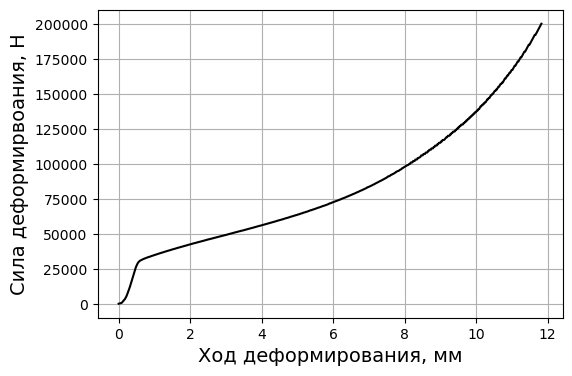

In [6]:
# Создаем объект класса Stress_strain
stress_strain = Stress_strain (load_stroke_data[:, 0], load_stroke_data[:,1], L0, A0, Le=Le)

# посмотрим на график силы по ходу деформирвоания
stress_strain.plot_graph(stress_strain.stroke, stress_strain.load, 'Ход деформирования, мм', 'Сила деформирвоания, Н')

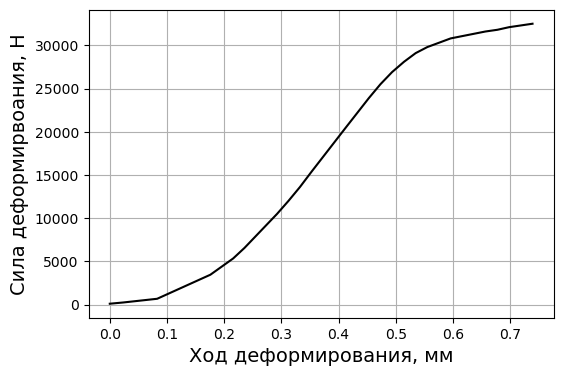

In [7]:
# посмотрим на упруго-пластическую часть графика
stress_strain.plot_graph(stress_strain.stroke[:25], stress_strain.load[:25], 'Ход деформирования, мм', 'Сила деформирвоания, Н')

In [8]:
# попробуем посчитать жесткость испытательной машины
_ = stress_strain.get_stifness()
print (f'Жесткость испытательной машины: {stress_strain.k:.3f}, Н/мм ')

Жесткость испытательной машины: 206910.821, Н/мм 


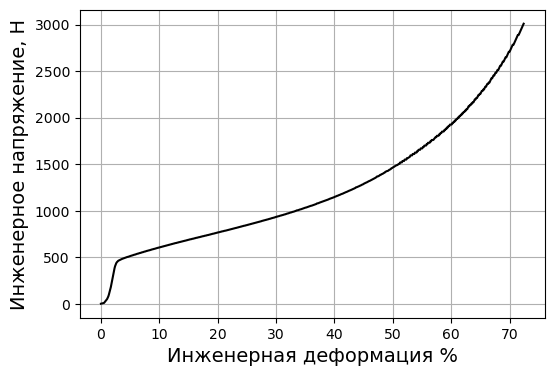

In [9]:
# посчитаем инженерные напряжения/деформации и посмотрим на график
_ = stress_strain.get_strain_eng() 
_ = stress_strain.get_stress_eng()

# посмотрим на график
stress_strain.plot_graph(stress_strain.strain_eng, stress_strain.stress_eng, 'Инженерная деформация %', 'Инженерное напряжение, Н')


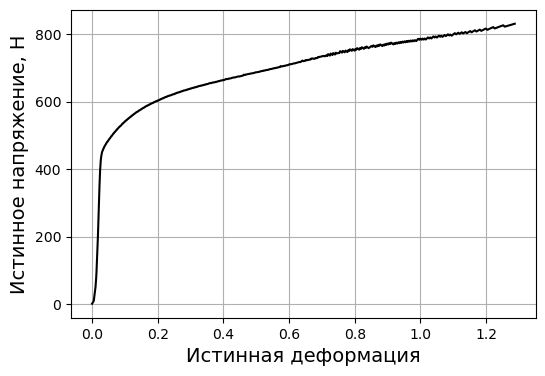

In [10]:
# посчитаем истинные напряжения/деформации и посмотрим на график
_ = stress_strain.get_strain_true() 
_ = stress_strain.get_stress_true()

# посмотрим на график
stress_strain.plot_graph(stress_strain.strain_true, stress_strain.stress_true, 'Истинная деформация', 'Истинное напряжение, Н')


    Предел прочности и равномерное удлинение мы определить по результатам испытания образца 
    на сжатие не сможем, так что ограничимся пределом текучести и модулем Юнга

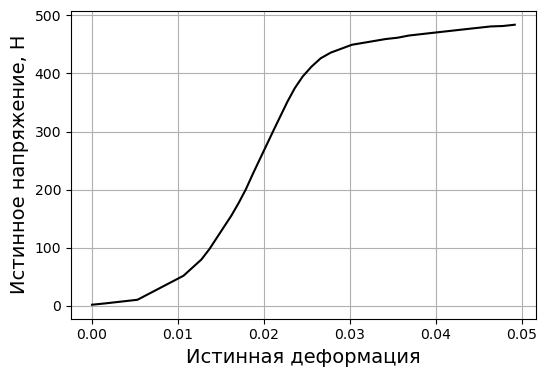

In [11]:
# Создадим объект для расчета мех. характиристик (модуля Юнга и предела текучести)
mech_properties = Mech_properties (stress_strain.strain_true, stress_strain.stress_true, stress_type = 'true')
# Посмотрим внимательнее на "около" упругую часть графика
filtr01 = mech_properties.strain <= 0.05
stress_strain.plot_graph(stress_strain.strain_true[filtr01], stress_strain.stress_true[filtr01], 'Истинная деформация', 'Истинное напряжение, Н')

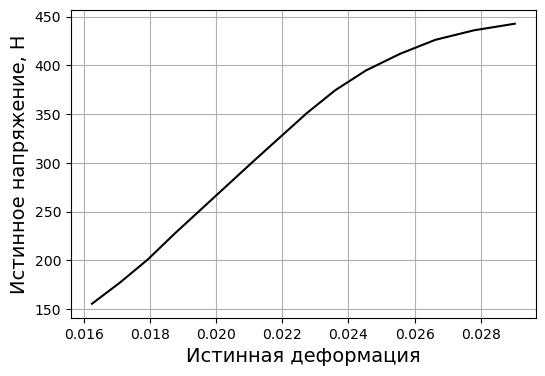

In [12]:
# откинем часть графика, которая явно вносит погрешность из-за выборки зазора в испытательной машине
filtr02 = (mech_properties.strain <= 0.03)&(mech_properties.strain >= 0.015)
# посмотрим что получилось:
stress_strain.plot_graph(stress_strain.strain_true[filtr02], stress_strain.stress_true[filtr02], 'Истинная деформация', 'Истинное напряжение, Н')

In [13]:
# Посчитаем модуль Юнга
strain_limit_left = 0.017
_ = mech_properties.get_E(strain_limit_left = strain_limit_left, strain_limit_right = 0.023)
print (f'Модуль Юнга равен: {mech_properties.E:.0f} МПа')

Модуль Юнга равен: 30790 МПа


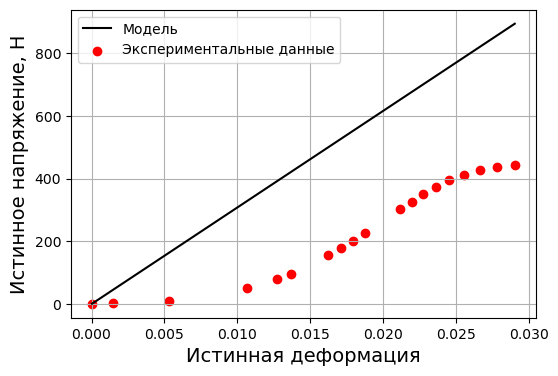

In [14]:
# визуализируем результат расчета модуля Юнга
filtr03 = mech_properties.strain <= 0.03
mech_properties.plot_experiment_vs_model([stress_strain.strain_true[filtr03], stress_strain.stress_true[filtr03]],
                                        [stress_strain.strain_true[filtr03], mech_properties.E*(stress_strain.strain_true[filtr03])],
                                        'Истинная деформация', 'Истинное напряжение, Н')

# Это очень странный результат, ну да ладно.

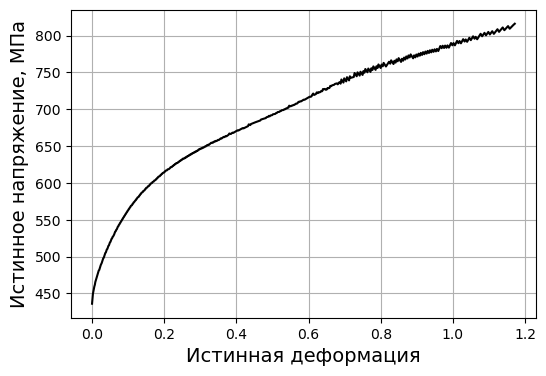

In [21]:
# Примим предел текучести yield_stress равным 430 МПа и определим кривую сопротивления
# пластической деформации
flow_stress = Stress_strain.get_flow_curve(mech_properties.strain, mech_properties.stress, 430, 1.2)
# Посмотрим на результат
Stress_strain.plot_graph(flow_stress[:, 0], flow_stress[:, 1], 'Истинная деформация', 'Истинное напряжение, МПа')

In [69]:
# Апроксимация данных моделью Свифта (к пятнице постараюсь какие-то более продвинутые модели разобрать)
# Определим функцию модели Свифта
def swift_model(eps, sigma0, K, n):
    return sigma0 + K * (eps ** n)
    
# Начальные приближения параметров
p0_swift = [420., 2,  2]

# допустимые границы параметров
bounds = ([390, 1, 0.01], [460, 1000, 3])

# Апроксимация данных
params_swift, _ = curve_fit(swift_model, flow_stress[:, 0], flow_stress[:,1], p0=p0_swift, bounds = bounds)

sigma0, K, n = params_swift
print(f'Модель Свифта: σ = {sigma0:.1f} + {K:.3f}·ε^{n:.3f}')

Модель Свифта: σ = 407.9 + 380.267·ε^0.394


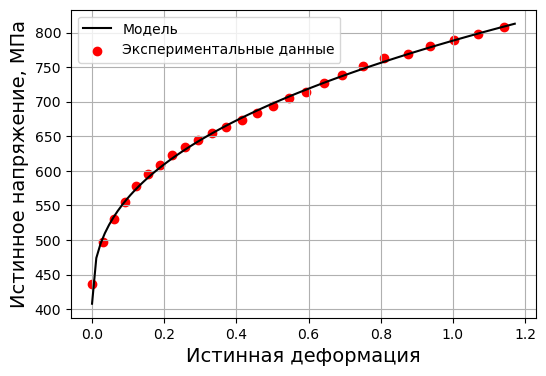

In [70]:
# сравним исходную кривую и модельную
# для модельной кривой подготовим вектор истинной деформации
strain_space = np.linspace(0, flow_stress[-1, 0], 100)
# Посчитаем значения напряжений по модели Свифта
stress_swift = swift_model(strain_space, sigma0, K, n)
# Сравним модель сэкспериментом
Stress_strain.plot_experiment_vs_model([flow_stress[::20, 0], flow_stress[::20,1]],
                                       [strain_space, stress_swift],
                                       'Истинная деформация', 'Истинное напряжение, МПа')